___
# Image Scraping and Modelling Project
___

In [ ]:
## importing dependencies

import numpy as np
import pandas as pd
import os
import cv2
from glob import glob

import matplotlib.pyplot as plt

from tensorflow.keras.layers import BatchNormalization,Conv2D,Dense,Dropout,MaxPool2D,Flatten,AveragePooling2D,GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
import tensorflow as tf

In [ ]:
# defining the image size for modelling
IMAGE_SIZE=[256,256]

In [ ]:
# path to the train and test directory
train_path = '/content/data/train'
test_path = '/content/data/train'

In [ ]:
# getting all the images path from train, test directories respectively ..

train_files = glob(train_path + "/*/*.jpg")
test_files = glob(test_path + "/*/*.jpg")

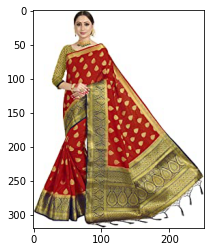

In [ ]:
plt.imshow(image.load_img(np.random.choice(train_files)))

## Data Augmentations and Data Splitting

In [ ]:
# create an instance of the imagedatagenerator

gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = 0.2,
    vertical_flip=True)

In [ ]:
# train and test data generator

train_gen = gen.flow_from_directory('data/train',target_size=IMAGE_SIZE,shuffle=True)
test_gen = gen.flow_from_directory('data/test',target_size=IMAGE_SIZE,shuffle=True)

Found 833 images belonging to 3 classes.
Found 337 images belonging to 3 classes.


In [ ]:
# the following directory gives the class indices

train_gen.class_indices

{'jeans': 0, 'saree': 1, 'trousers': 2}

___

## Model Building

We will be performing Transfer learning as those will gives us State of the Art Results ....

In [ ]:
# Importing the VGG 16 Model and its preprocessed Inputs

from tensorflow.keras.applications import VGG16 as Pretrained_Model
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
# setting weights

ptm = Pretrained_Model(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top =False)

In [ ]:
 # freezing the pretrained models
 ptm.trainable = False

In [ ]:
# map the data into feature vectors
# keras image data generators return one hot codded classes

x = Flatten()(ptm.output)
prediction = Dense(3,activation='softmax')(x)

In [ ]:
# create a new model instance

model = tf.keras.models.Model(inputs=ptm.input,outputs=prediction)

In [ ]:
# get the summary of the model

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [ ]:
# compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# fitting the model

Early_Stopping = tf.keras.callbacks.EarlyStopping(verbose=3,patience=3)
model.fit(train_gen,epochs=12,
          validation_data=test_gen)

Epoch 1/12
27/27 [==============================] - 17s 647ms/step - loss: 0.1345 - accuracy: 0.9400 - val_loss: 0.4608 - val_accuracy: 0.8338
Epoch 2/12
27/27 [==============================] - 17s 639ms/step - loss: 0.1013 - accuracy: 0.9700 - val_loss: 0.7724 - val_accuracy: 0.7596
Epoch 3/12
27/27 [==============================] - 17s 634ms/step - loss: 0.1891 - accuracy: 0.9172 - val_loss: 0.5354 - val_accuracy: 0.8427
Epoch 4/12
27/27 [==============================] - 17s 635ms/step - loss: 0.1709 - accuracy: 0.9268 - val_loss: 0.8441 - val_accuracy: 0.7626
Epoch 5/12
27/27 [==============================] - 17s 636ms/step - loss: 0.1479 - accuracy: 0.9364 - val_loss: 0.5191 - val_accuracy: 0.8398
Epoch 6/12
27/27 [==============================] - 17s 638ms/step - loss: 0.1232 - accuracy: 0.9484 - val_loss: 0.4876 - val_accuracy: 0.8546
Epoch 7/12
27/27 [==============================] - 17s 639ms/step - loss: 0.0941 - accuracy: 0.9592 - val_loss: 0.5418 - val_accuracy: 0.8309

In [ ]:
# create a dataframe to show the metrics per epoch

losses = pd.DataFrame(model.history.history)
losses

,loss,accuracy,val_loss,val_accuracy
0,0.134504,0.939976,0.460784,0.833828
1,0.101309,0.969988,0.772406,0.759644
2,0.189138,0.917167,0.535361,0.842730
3,0.170861,0.926771,0.844059,0.762611
4,0.147873,0.936375,0.519072,0.839763
5,0.123221,0.948379,0.487635,0.854599
6,0.094144,0.959184,0.541837,0.830861
7,0.080961,0.966387,0.527974,0.833828
8,0.179659,0.944778,0.594119,0.821958
9,0.439795,0.858343,0.590677,0.818991


No handles with labels found to put in legend.


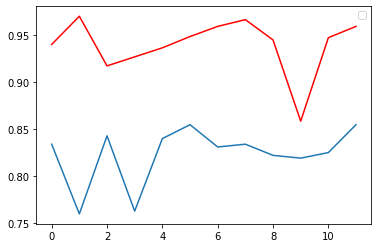

In [ ]:
# plotting the accuracy of the model

plt.plot(losses['accuracy'],color='red')
plt.plot(losses['val_accuracy'])
plt.legend()

No handles with labels found to put in legend.


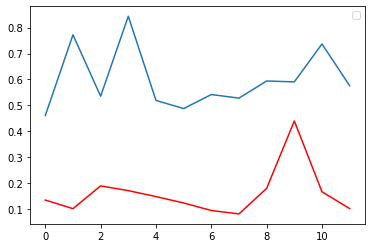

In [ ]:
# plotting the lss of the model

plt.plot(losses['loss'],color='red')
plt.plot(losses['val_loss'])
plt.legend()

## Predicting on a random image

In [ ]:
name_labels_df = pd.DataFrame(list(test_gen.class_indices.items()),columns = ['names','labels'],index=None)

In [ ]:
name_labels_df

,names,labels
0,jeans,0
1,saree,1
2,trousers,2


In [ ]:
#predicting any random image
import numpy as np
from google.colab import files
from keras.preprocessing import image


def predict_random_image():
  img = image.load_img(np.random.choice(test_files), target_size=IMAGE_SIZE)
  x = image.img_to_array(img)
  plt.imshow(img)
  x = np.expand_dims(x, axis=0) /255.0
  result_df = pd.DataFrame(list(model.predict(x)[0]),index=name_labels_df.names.values,columns=['result'])
  print(result_df.result.idxmax())

saree


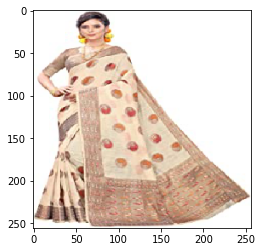

In [ ]:
predict_random_image()

trousers


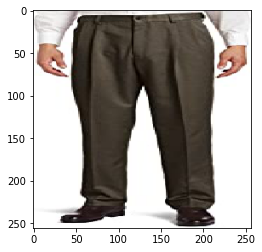

In [ ]:
predict_random_image()

jeans


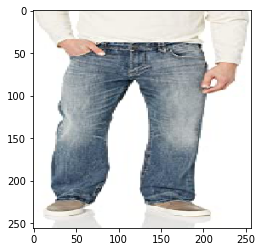

In [ ]:
predict_random_image()

## Saving the model

In [ ]:
# model artifact

model.save("image_classifier_model.h5")

In [ ]:
# Saved model

model.save('image_classifier_model')

INFO:tensorflow:Assets written to: image_classifier_model/assets
